## Makemore MLP
- Code from [karpathy/nn-zero-to-hero/lectures/makemore/makemore_part2_mlp.ipynb](https://github.com/karpathy/nn-zero-to-hero/blob/master/lectures/makemore/makemore_part2_mlp.ipynb)
    - Re-factored to follow standard PyTorch workflows, while still keeping it simple and readable
    - Some additional notes / comments

### Discussion: Bigram to MLP

- Our bigram "table" (joint distribution $P(x,y)$) had 27 rows because we were only looking at a single character (26 chars plus the special token for begin/end)
    - E.g. block_size=1
- The number of rows would grow exponentially as $\text{vocab-size}^\text{context-len}$
    - If context_len = 1, num_rows = 27
    - If context_len = 2, num_rows = 27*27 = 729
    - If block_size = 3, num_rows = 27*27*27 = 19683
    - If context_len = 4, num_rows = 27*27*27*27 = 531441
    - If context_len = 128, num_rows = 27^128 = 1.639e183 (craaaazy)

### Imports and Paths

In [49]:
# Imports
from pathlib import Path
import torch
from torch import nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from tqdm import tqdm
%matplotlib inline

# Paths (modify as necessary)
names_txt = Path('~/dl_from_scratch/dl_scratch/makemore/names.txt').expanduser()
device = 'cuda' if torch.cuda.is_available() else 'cpu'

### Build Dataset

#### Load Data / Build Vocabulary

In [77]:
# read in all the words
words = open(names_txt, 'r').read().splitlines()
print(f"Num words: {len(words)}")
print(f"First 10 words: {words[:10]}")

# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(f"Char to int (stoi): {stoi}")
print(f"Int to char (itos): {itos}")
print(f"Vocab size: {vocab_size}")

Num words: 32033
First 10 words: ['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia', 'harper', 'evelyn']
Char to int (stoi): {'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26, '.': 0}
Int to char (itos): {1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
Vocab size: 27


#### Dataset Example

In [73]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

X, Y = [], []
for w in words[:3]:
  
  print(f"Input: {w}")
  print(f"Samples:")
  
  context = [0] * block_size  # Pad (special character)
  for ch in w + '.':
    ix = stoi[ch]
    X.append(context)
    Y.append(ix)
    context_str = ''.join(itos[i] for i in context)
    print(f"  {context_str} ---> {itos[ix]}    or    {context} ---> {ix}")  # x_i ---> y_i
    context = context[1:] + [ix]  # Slide left and append current char idx
  
X = torch.tensor(X, device=device)
Y = torch.tensor(Y, device=device)

Input: yuheng
Samples:
  ... ---> y    or    [0, 0, 0] ---> 25
  ..y ---> u    or    [0, 0, 25] ---> 21
  .yu ---> h    or    [0, 25, 21] ---> 8
  yuh ---> e    or    [25, 21, 8] ---> 5
  uhe ---> n    or    [21, 8, 5] ---> 14
  hen ---> g    or    [8, 5, 14] ---> 7
  eng ---> .    or    [5, 14, 7] ---> 0
Input: diondre
Samples:
  ... ---> d    or    [0, 0, 0] ---> 4
  ..d ---> i    or    [0, 0, 4] ---> 9
  .di ---> o    or    [0, 4, 9] ---> 15
  dio ---> n    or    [4, 9, 15] ---> 14
  ion ---> d    or    [9, 15, 14] ---> 4
  ond ---> r    or    [15, 14, 4] ---> 18
  ndr ---> e    or    [14, 4, 18] ---> 5
  dre ---> .    or    [4, 18, 5] ---> 0
Input: xavien
Samples:
  ... ---> x    or    [0, 0, 0] ---> 24
  ..x ---> a    or    [0, 0, 24] ---> 1
  .xa ---> v    or    [0, 24, 1] ---> 22
  xav ---> i    or    [24, 1, 22] ---> 9
  avi ---> e    or    [1, 22, 9] ---> 5
  vie ---> n    or    [22, 9, 5] ---> 14
  ien ---> .    or    [9, 5, 14] ---> 0


#### Full Dataset

In [52]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words, split, x_var, y_var):  
  X, Y = [], []
  
  for w in words:
    context = [0] * block_size  # Initial 
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X, device=device)
  Y = torch.tensor(Y, device=device)
  print(f"{split.capitalize()} split: {x_var}.shape: {X.shape}, {y_var}.shape: {Y.shape}")
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,  Ytr  = build_dataset(words[:n1], "train", "Xtr", "Ytr")    # 80%
Xdev, Ydev = build_dataset(words[n1:n2], "val", "Xdev", "Ydev")  # 10%
Xte,  Yte  = build_dataset(words[n2:], "test", "Xte", "Yte")     # 10%

Train split: Xtr.shape: torch.Size([182625, 3]), Ytr.shape: torch.Size([182625])
Val split: Xdev.shape: torch.Size([22655, 3]), Ydev.shape: torch.Size([22655])
Test split: Xte.shape: torch.Size([22866, 3]), Yte.shape: torch.Size([22866])


### Build MLP Model

In [ ]:
class MLP(nn.Module):
    def __init__(
        self,
        block_size: int = 3,  # Aka context length or sequence length
        n_embd: int = 10, 
        n_hidden: int = 200, 
        vocab_size: int = 27,
        device: str = 'cuda' if torch.cuda.is_available() else 'cpu',
    ):
        super().__init__()
        self.n_embd = n_embd
        
        g = torch.Generator(device=device).manual_seed(2147483647) # for reproducibility    
        self.C = torch.randn((vocab_size, n_embd), generator=g, device=device)  # Embedding matrix        
        self.W1 = torch.randn((block_size*n_embd, n_hidden), generator=g, device=device)
        self.b1 = torch.randn(n_hidden, generator=g, device=device)        
        self.W2 = torch.randn((n_hidden, vocab_size), generator=g, device=device)
        self.b2 = torch.randn(vocab_size, generator=g, device=device)

        # Hack, set requires_grad = True b/c didn't declare as nn.Parameters in this version
        parameters = self.parameters()
        for p in parameters:
            p.requires_grad = True

        print(f"Num params: {sum(p.nelement() for p in parameters)}")

    def zero_grad(self):
        for p in self.parameters():
            p.grad = None

    def parameters(self) -> list[torch.Tensor]:
        # Hack, overwrite std impl. since we didn't declare as nn.Parameters in this version
        return [self.C, self.W1, self.b1, self.W2, self.b2]

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        #  x.shape; (N,L) = (32,3)
        emb = self.C[x] # (32, 3) -> (32, 3, 10)
        
        # (32, 30) @ (30, 200) -> (32, 200)
        h = torch.tanh(emb.view(-1, block_size * self.n_embd) @ self.W1 + self.b1) 
        
        logits = h @ self.W2 + self.b2  #  (32, 200) @ (200, 27) -> (32, 27)
        return logits
        
    def loss(self, x: torch.Tensor, y: torch.Tensor) -> torch.Tensor:
        #  x.shape; (N,L) = (32,3)
        #  y.shape: (N,) = (32,)
        logits = self.forward(x)  # (32, 3) -> (32, 27)
        loss = F.cross_entropy(logits, y)  # (32, 27) -> (1,)
        return loss
        

### Train Loop

In [63]:
# Hyperparameters
n_embd = 10   # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

# Build model
model = MLP(
    block_size=block_size,  # e.g. 3 above
    n_embd=n_embd, 
    n_hidden=n_hidden, 
    vocab_size=vocab_size,
    device=device,
)

lossi = []
stepi = []

# Train
max_steps = 200000
print_loss_steps = max_steps // 10
for i in tqdm(range(max_steps), desc="iter", total=max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (32,))  # (32,)
  x = Xtr[ix]  # (32, 3) or (32, block_size)
  y = Ytr[ix]
  
  # forward pass
  loss = model.loss(x, y)
  
  # backward pass
  model.zero_grad()
  loss.backward()
  
  # update
  lr = 0.1 if i < 100000 else 0.01
  for p in model.parameters():
    p.data += -lr * p.grad  # pyright: ignore[reportOperatorIssue]

  # track stats
  stepi.append(i)
  lossi.append(loss.log10().item())
  
  # print
  if i == 0 or (i+1) % print_loss_steps == 0:
    print(f"Iter [{i+1}/{max_steps}]: loss={loss.item():.3f}")

print(f"Final loss: {loss.item()}")

Num params: 11897


iter:   0%|          | 30/200000 [00:00<11:23, 292.54it/s]

Iter [1/200000]: loss=28.501


iter:  10%|█         | 20053/200000 [00:36<05:02, 594.57it/s]

Iter [20000/200000]: loss=2.065


iter:  20%|██        | 40088/200000 [01:16<05:14, 508.24it/s]

Iter [40000/200000]: loss=2.506


iter:  30%|███       | 60063/200000 [01:55<04:04, 571.26it/s]

Iter [60000/200000]: loss=2.182


iter:  40%|████      | 80084/200000 [02:36<04:21, 457.95it/s]

Iter [80000/200000]: loss=2.808


iter:  50%|█████     | 100100/200000 [03:15<03:23, 492.04it/s]

Iter [100000/200000]: loss=2.127


iter:  60%|██████    | 120059/200000 [03:56<02:31, 527.44it/s]

Iter [120000/200000]: loss=1.952


iter:  70%|███████   | 140042/200000 [04:35<02:46, 359.77it/s]

Iter [140000/200000]: loss=2.060


iter:  80%|████████  | 160097/200000 [05:15<01:13, 542.35it/s]

Iter [160000/200000]: loss=2.040


iter:  90%|█████████ | 180079/200000 [05:55<00:36, 540.47it/s]

Iter [180000/200000]: loss=1.874


iter: 100%|██████████| 200000/200000 [06:38<00:00, 502.01it/s]

Iter [200000/200000]: loss=1.768
Final loss: 1.7684181928634644


### Evaluate

In [67]:
# Cross entropy loss on entire training set
loss = model.loss(Xtr, Ytr)
loss

tensor(2.1088, device='cuda:0', grad_fn=<NllLossBackward0>)

In [68]:
# Cross entropy loss on entire validation set
loss = model.loss(Xdev, Ydev)
loss

tensor(2.1548, device='cuda:0', grad_fn=<NllLossBackward0>)

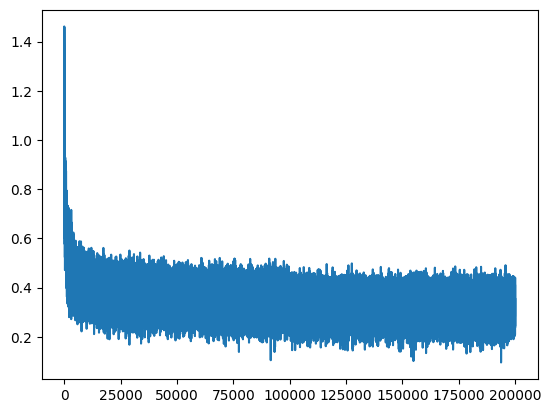

In [69]:
# Plot loss
plt.plot(stepi, lossi)

### Generate
- This is much better than bigram, but not great yet (see part 3)

In [ ]:
# sample from the model
g = torch.Generator(device=device).manual_seed(2147483647 + 10)

for _ in range(20):
    out = []
    context = [0] * block_size  # initialize with `...`
    while True:    
        x = torch.tensor([context], device=device)  # (1,block_size)
        logits = model.forward(x)  # (1,block_size) -> (1,27)
        
        probs = F.softmax(logits, dim=-1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break
    
    print(''.join(itos[i] for i in out))

bree.
sahamniel.
frendarry.
reysley.
jeidenorus.
jheman.
jagrace.
edwy.
quinn.
canti.
elion.
aarshtento.
kengeldyn.
zazhrann.
jurlana.
doria.
aviel.
thanekhoris.
adesterick.
annax.
